In [1]:
import pandas as pd


In [2]:
# download file "market_logs.log" and extract data
market_logs = pd.read_csv("market_logs.log", header=None, names=['time_side','price','vol_glass'])
market_logs['time'] = market_logs['time_side'].apply(lambda x: int(x.split()[4]))
market_logs['side'] = market_logs['time_side'].apply(lambda x: int(x.split()[7]))
market_logs['price'] = market_logs['price'].apply(lambda x: float(x.split()[1]))
market_logs['volume'] = market_logs['vol_glass'].apply(lambda x: int(x.split()[2]))
market_logs['volume_bid'] = market_logs['vol_glass'].apply(lambda x: int(x.split()[6].split('@')[0]))
market_logs['volume_ask'] = market_logs['vol_glass'].apply(lambda x: int(x.split('@')[2]))
market_logs['bid_price'] = market_logs['vol_glass'].apply(lambda x: float(x.split('@')[1].split('x')[0]))
market_logs['ask_price'] = market_logs['vol_glass'].apply(lambda x: float(x.split('@')[1].split('x')[1]))

del market_logs['time_side']
del market_logs['vol_glass']

# mid_price = (ask_price + bid_price)/2 calculating
market_logs['mid_price'] = (
    market_logs['bid_price'] + market_logs['ask_price']) / 2

print(market_logs)


         price                 time  side  volume  volume_bid  volume_ask  \
0       1108.9  1622505601191796236    -1      36           6         104   
1       1108.7  1622505601222248272    -1      17          10          23   
2       1108.5  1622505601364445668    -1      20          16          23   
3       1108.6  1622505601405325968     1       1          16          22   
4       1108.3  1622505601406994624    -1      16          18          12   
...        ...                  ...   ...     ...         ...         ...   
397797  1150.5  1627626542759155628     1       1         217          92   
397798  1150.5  1627626543983252140     1       1         187         126   
397799  1150.5  1627626549091604988     1      94           6         365   
397800  1150.5  1627626549092524892    -1       6         177         365   
397801  1150.5  1627626549492660420    -1       2         197         311   

        bid_price  ask_price  mid_price  
0          1108.7     1108.8    1

In [3]:

# download file "exec_logs.log" and extract data
exec_logs = pd.read_csv("exec_logs.log", header=None, names=[
                        'time', 'side', 'price', 'traded_volume', 'volume_left', 'delta_execsend'])
exec_logs['time'] = exec_logs['time'].apply(lambda x: int(x.split()[4]))
exec_logs['side'] = exec_logs['side'].apply(lambda x: int(x.split()[1]))
exec_logs['price'] = exec_logs['price'].apply(lambda x: float(x.split()[1]))
exec_logs['traded_volume'] = exec_logs['traded_volume'].apply(lambda x: int(x.split()[2]))
exec_logs['volume_left'] = exec_logs['volume_left'].apply(lambda x: int(x.split()[4]))
exec_logs['delta_execsend'] = exec_logs['delta_execsend'].apply(
    lambda x: int(x.split()[1]))
print(exec_logs)


                     time  side   price  traded_volume  volume_left  \
0     1622505601222248272     1  1108.6              1           10   
1     1622505601424113404    -1  1108.4              1           22   
2     1622505601604667896     1  1108.3              1            2   
3     1622505602982200992    -1  1108.4              1            1   
4     1622505603600579508     1  1108.3              1            6   
...                   ...   ...     ...            ...          ...   
8677  1627626326117581668     1  1149.9              1          564   
8678  1627626397873668620    -1  1150.2              1          331   
8679  1627626412584847188     1  1150.1              1           97   
8680  1627626473991536064    -1  1150.4              1           10   
8681  1627626512859773452     1  1150.6              1           15   

      delta_execsend  
0           30451968  
1           17118720  
2          153866496  
3          153371136  
4          618378496  
...      

In [4]:
# merge market_logs and exec_logs

merge_log = market_logs.merge(exec_logs, how='outer', on='time', sort=True, indicator=True)
merge_log["mid_price"].bfill(axis=None, inplace=True)

# calculate dmid5
df4calc = merge_log[["time", "price_y", "side_y", "delta_execsend"]
              ][merge_log["side_y"].notna() == True].reset_index(drop=True)
for i, tm in enumerate(df4calc["time"]):
    mc = merge_log["time"][merge_log["time"] < (tm+5000000000)]
    mcind = len(mc)
    midprice5 = merge_log.at[mcind, "mid_price"]
    df4calc.at[i, "dmid5"] = (midprice5 - df4calc.at[i, "price_y"]
                              ) * df4calc.at[i, "side_y"]
display(df4calc)


,time,price_y,side_y,delta_execsend,dmid5
0,1622505601222248272,1108.6,1.0,3.045197e+07,0.05
1,1622505601424113404,1108.4,-1.0,1.711872e+07,-0.05
2,1622505601604667896,1108.3,1.0,1.538665e+08,0.15
3,1622505602982200992,1108.4,-1.0,1.533711e+08,-0.15
4,1622505603600579508,1108.3,1.0,6.183785e+08,0.05
...,...,...,...,...,...
8677,1627626326117581668,1149.9,1.0,2.381312e+06,-0.05
8678,1627626397873668620,1150.2,-1.0,1.296281e+09,0.05
8679,1627626412584847188,1150.1,1.0,1.470386e+10,0.05
8680,1627626473991536064,1150.4,-1.0,1.213418e+10,-0.05


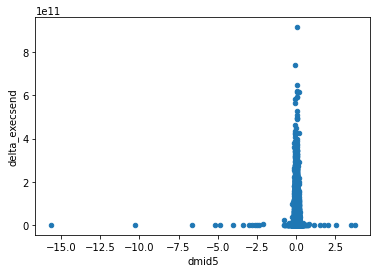

In [5]:
# plotting graph dmid5 - delta_execsend

dplot = df4calc[["dmid5", "delta_execsend"]]
ax1 = dplot.plot.scatter(x='dmid5', y='delta_execsend')


In [6]:
print("pearson correlation=", dplot.corr("pearson").iat[0, 1])
print("kendall correlation=", dplot.corr("kendall").iat[0, 1])
print("spearman correlation=", dplot.corr("spearman").iat[0, 1])


pearson correlation= 0.02288395808170557
kendall correlation= 0.05806087595061514
spearman correlation= 0.08292806294812888
